## Проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:
- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 
### 1.3 Вопросы

Предлагаем вам ответить на следующие вопросы:

- На какие метрики вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
# выгружаем библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
from scipy.stats import bootstrap
from scipy.stats import chi2_contingency

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from urllib.parse import urlencode

In [2]:
# ссылки на данные с Яндекс диска

groups_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
# функция для открытия данных с Яндекс диска

def get_yandex_csv(public_key, sep):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=sep)

### groups.csv 
- файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [4]:
groups = get_yandex_csv(groups_key, ';')
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
groups.duplicated().sum()

0

In [7]:
groups.id.nunique() == groups.shape[0]

True

In [8]:
count_users = groups\
    .groupby('grp', as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'count_users'})
count_users

,grp,count_users
0,A,14671
1,B,59813


В файле нет пропусков и дубликатов, id являются уникальными, соответствуют кол-ву строк файла
- группа A (контрольная) - 14 671 пользователь
- группа B (экспериментальная) - 59 813 пользователей

### groups_add.csv 
- дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [9]:
groups_add = get_yandex_csv(groups_add_key, ',')
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [10]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [11]:
groups_add.duplicated().sum()

0

In [12]:
groups_add.id.nunique() == groups_add.shape[0]

True

In [13]:
count_users_add = groups_add\
    .groupby('grp', as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'count_users_add'})
count_users_add

,grp,count_users_add
0,A,22
1,B,70


В файле нет пропусков и дубликатов, id являются уникальными, соответствуют кол-ву строк файла.
- группа A (контрольная) - 22 пользователя
- группа B (экспериментальная) - 70 пользователей

### active_studs.csv 
- файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [14]:
active_studs = get_yandex_csv(active_studs_key, ' ')
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [15]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [16]:
active_studs.duplicated().sum()

0

In [17]:
active_studs.student_id.nunique() == active_studs.shape[0]

True

In [18]:
# присвоим 1 каждому активному пользователю 
active_studs['active'] = 1
active_studs.head(3)

,student_id,active
0,581585,1
1,5723133,1
2,3276743,1


In [19]:
# переименуем колонку
active_studs = active_studs.rename(columns={'student_id': 'id'})
active_studs.head(2)

,id,active
0,581585,1
1,5723133,1


В файле нет пропусков и дубликатов, id являются уникальными, соответствуют кол-ву строк файла
- активных пользователей - 8341

### checks.csv 
- файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [20]:
checks = get_yandex_csv(checks_key, ';')
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [21]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [22]:
checks.duplicated().sum()

0

In [23]:
checks.student_id.nunique() == checks.shape[0]

True

In [24]:
# присвоим 1 каждому оплатившему пользователю
checks['paid'] = 1

In [25]:
# переименуем колонку
checks = checks.rename(columns={'student_id': 'id'})
checks.head(2)

,id,rev,paid
0,1627,990.0,1
1,3185,690.0,1


In [26]:
# общая сумма в файле
checks.rev.sum()

573326.0035999999

В файле нет пропусков и дубликатов, id являются уникальными, соответствуют кол-ву строк файла.
- кол-во пользователей, которые произвели оплату - 541
- общая сумма оплат в файле  - 573 326 руб

### Объединение таблиц и исследование данных

In [27]:
groups.head(1)

,id,grp
0,1489,B


In [28]:
groups_add.head(1)

,id,grp
0,5694584,B


In [29]:
# пробуем смержить оба файла, но видим, что id не совпадают
groups.merge(groups_add, on='id')

,id,grp_x,grp_y


In [30]:
# соединим оба файла 
shared_group = pd.concat([groups, groups_add], ignore_index=True).rename(columns={'grp': 'group'})
shared_group.head(3)

,id,group
0,1489,B
1,1627,A
2,1768,B


In [31]:
shared_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   group   74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [32]:
groups.shape[0]+groups_add.shape[0]

74576

In [33]:
shared_group.id.nunique()==shared_group.shape[0]

True

In [34]:
total_users = shared_group\
    .groupby('group',as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'count_users'})
total_users

,group,count_users
0,A,14693
1,B,59883


In [35]:
total_users['percent'] = round(total_users.count_users / shared_group.shape[0]*100, 2)
total_users

,group,count_users,percent
0,A,14693,19.7
1,B,59883,80.3


Все id уникальны, видим значительные различия по кол-ву пользователей в группах
    
- группа A - 14 693 пользователя (19.7%)
- группа B - 59 883 пользователя (80.3%)

In [85]:
# смержим общую таблицу пользователей с таблицей оплат
paid_users = shared_group.merge(checks, on='id')
paid_users.head()

,id,group,rev,paid
0,1627,A,990.0,1
1,3185,B,690.0,1
2,25973,B,690.0,1
3,26280,B,690.0,1
4,100300,B,990.0,1


In [37]:
# посмотрим на кол-во оплат по группам
paid_users.groupby('group', as_index=False).agg({'id': 'count'})

,group,id
0,A,107
1,B,434


In [38]:
# посмотрим на общую выручку по группам
paid_users.groupby('group', as_index=False).agg({'rev': 'sum'})

,group,rev
0,A,92096.0000
1,B,481230.0036


In [39]:
# объединим таблицы active_studs с checks и переименуем колонки
active_checks = active_studs.merge(checks, on='id', how='left')\
    .rename(columns={'rev': 'revenue'})
active_checks.head(3)

,id,active,revenue,paid
0,581585,1,NaN,NaN
1,5723133,1,NaN,NaN
2,3276743,1,NaN,NaN


In [40]:
active_checks.shape[0]

8341

In [41]:
# дубликатов нет
active_checks.duplicated().sum()

0

In [42]:
# пропусков 7949
active_checks.isna().sum()

id            0
active        0
revenue    7949
paid       7949
dtype: int64

In [43]:
active_checks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       8341 non-null   int64  
 1   active   8341 non-null   int64  
 2   revenue  392 non-null    float64
 3   paid     392 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 325.8 KB


In [44]:
checks.shape[0] - active_checks.revenue.count() 

149

Замечаем, что в таблицу активных пользователей попали 392 id пользователя из 541, которые проводили платеж.
Разница - 149 пользователей. Можем предположить, что либо был технический сбой, либо возможно был автоплатеж, тк во время эксперимента эти пользователи были неактивны.

Для проведения теста нам нужны те пользователи, которые зашли на платформу в дни эксперимента. Принимаем решение, что 149 пользователей, id которых нет в списке активных пользователей, далее учитывать не будем.

In [45]:
# объединим файлы в итоговую таблицу
general_file = shared_group.merge(active_checks, on='id', how='left')
general_file.head()

,id,group,active,revenue,paid
0,1489,B,NaN,NaN,NaN
1,1627,A,1.0,990.0,1.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [46]:
general_file.duplicated().sum()

0

In [47]:
general_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       74576 non-null  int64  
 1   group    74576 non-null  object 
 2   active   8341 non-null   float64
 3   revenue  392 non-null    float64
 4   paid     392 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.4+ MB


In [48]:
# кол-во пропусков 
general_file.isna().sum()

id             0
group          0
active     66235
revenue    74184
paid       74184
dtype: int64

In [49]:
# заполним все пропуски 0
general_file = general_file.fillna(0)
general_file.head(3)

,id,group,active,revenue,paid
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0


In [50]:
# посмотрим как распределяются пользователи по группам
percent_total = general_file\
    .groupby(['group', 'active', 'paid'], as_index=False)\
    .agg({'id': 'count', 'revenue': 'sum'})\
    .rename(columns={'id': 'users_count', 'revenue': 'total_sum'})
percent_total

,group,active,paid,users_count,total_sum
0,A,0.0,0.0,13155,0.0000
1,A,1.0,0.0,1460,0.0000
2,A,1.0,1.0,78,72820.0000
3,B,0.0,0.0,53080,0.0000
4,B,1.0,0.0,6489,0.0000
5,B,1.0,1.0,314,394974.0035


In [51]:
# определим по группам % активных пользователей и % распределения оплат
percent_total['%users'] = round(percent_total.users_count / general_file.id.count()*100, 2)
percent_total['%total_sum'] = round(percent_total.total_sum / general_file.query('active == 1')['revenue'].sum()*100, 2)
percent_total

,group,active,paid,users_count,total_sum,%users,%total_sum
0,A,0.0,0.0,13155,0.0000,17.64,0.00
1,A,1.0,0.0,1460,0.0000,1.96,0.00
2,A,1.0,1.0,78,72820.0000,0.10,15.57
3,B,0.0,0.0,53080,0.0000,71.18,0.00
4,B,1.0,0.0,6489,0.0000,8.70,0.00
5,B,1.0,1.0,314,394974.0035,0.42,84.43


В эксперименте участвовало:
- группа А (контрольная) - 2.06% от всех пользователей (1 538 польз-лей)
- группа В (эксперементальная) - 9.12% от всех пользователей (6 803 польз-лей)

Распределение оплат на группам:
- группа А (контрольная) - 15.57% от общей суммы оплат (72 820 руб)
- группа В (эксперементальная) - 84.43% от общей суммы оплат (394 974 руб)

In [52]:
# нам нужны активные пользователи, которые зашли на сайт в дни проведения эксперимента
general_file_active = general_file.query('active == 1')
general_file_active.head(3)

,id,group,active,revenue,paid
1,1627,A,1.0,990.0,1.0
10,2085,B,1.0,0.0,0.0
12,2215,B,1.0,0.0,0.0


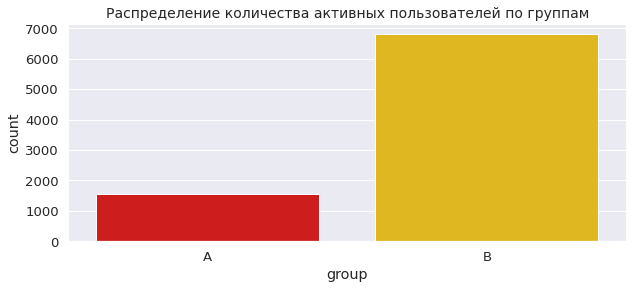

In [53]:
# визуализируем распределение кол-ва пользователей по группам
sns.set(font_scale=1.2, rc={'figure.figsize':(10, 4)})
sns.countplot(x='group', data = general_file_active, palette='hot')
plt.title('Распределение количества активных пользователей по группам', fontsize=14)
plt.show()

In [54]:
# посчитаем кол-во пользователей по группам и по сумме оплаты
users_count = general_file_active\
    .groupby(['group', 'revenue'], as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'users_count'})
users_count.head()

,group,revenue,users_count
0,A,0.0,1460
1,A,199.0,5
2,A,290.0,25
3,A,398.0,1
4,A,489.0,2


In [55]:
# кол-во пользователей по группам, не совершившие оплату
no_paid = users_count.query('revenue ==0')[['group', 'users_count']]
no_paid['%no_paid'] = round(no_paid.users_count / no_paid.users_count.sum()*100, 2)
no_paid

,group,users_count,%no_paid
0,A,1460,18.37
24,B,6489,81.63


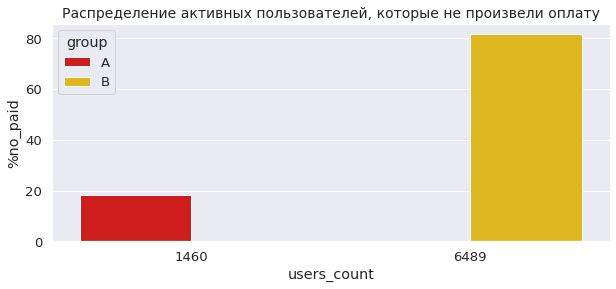

In [56]:
# визуализируем распределение кол-ва пользователей по группам, НЕ совершившие оплату
sns.set(font_scale=1.2, rc={'figure.figsize':(10, 4)})
sns.barplot(data=no_paid, x='users_count', y='%no_paid', hue='group', palette='hot')
plt.title('Распределение активных пользователей, которые не произвели оплату', fontsize=14)
plt.show()

In [57]:
# кол-во клиентов по группам, совершившие оплату
paid = general_file_active\
    .query('revenue != 0')\
    .groupby('group', as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'customers_count'})
paid['%paid'] = round(paid.customers_count / paid.customers_count.sum()*100, 2)
paid

,group,customers_count,%paid
0,A,78,19.9
1,B,314,80.1


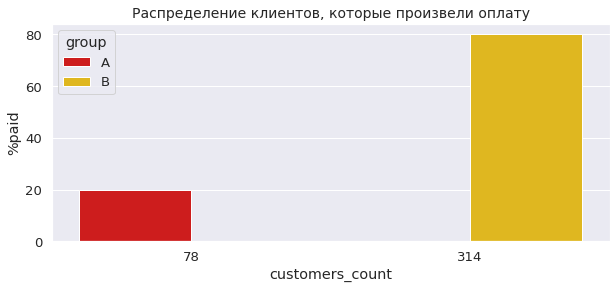

In [58]:
# визуализируем распределение кол-ва пользователей по группам, совершившие оплату
sns.set(font_scale=1.2, rc={'figure.figsize':(10,4)})
sns.barplot(data=paid, x='customers_count', y='%paid', hue='group', palette='hot')
plt.title('Распределение клиентов, которые произвели оплату', fontsize=14)
plt.show()

In [59]:
# сформируем файл клиентов, которые произвели оплату
customers = general_file_active.query('revenue > 0').rename(columns={'revenue': 'check_sum'})
customers.head()

,id,group,active,check_sum,paid
1,1627,A,1.0,990.0000,1.0
220,100300,B,1.0,990.0000,1.0
320,108270,B,1.0,290.0000,1.0
3779,264473,B,1.0,1900.0001,1.0
4187,274352,B,1.0,690.0000,1.0


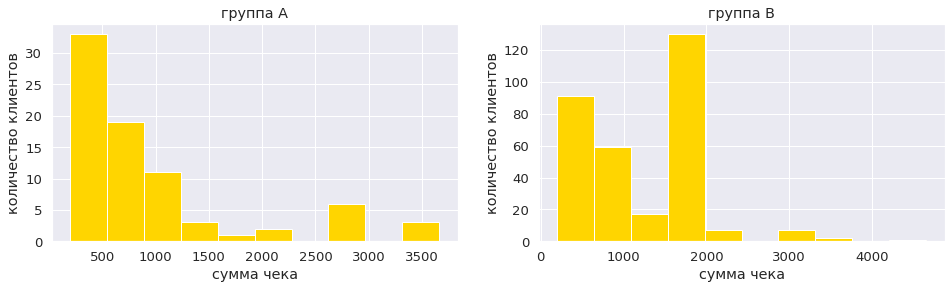

In [60]:
# визуализируем количество клиентов по сумме чека по каждой группе 
group_A = customers.query('group == "A"')
group_B = customers.query('group == "B"')
sns.set(font_scale=1.2, rc={'figure.figsize':(16,4)}, palette='hsv')
fig, axs = plt.subplots(1, 2)

axs[0].hist(group_A['check_sum'], linewidth=1, edgecolor="white")
axs[0].set_title('группа А')
axs[0].set(xlabel='сумма чека', ylabel='количество клиентов')
axs[1].hist(group_B['check_sum'], linewidth=1, edgecolor="white")
axs[1].set_title('группа В')
axs[1].set(xlabel='сумма чека', ylabel='количество клиентов')
sns.histplot()
plt.show()

###  Выводы исследования объединения данных
- группа А - контрольная 
- группа В - эксперементальная/целевая   
#### 74 576 уникальных пользователей в общем файле
- группа A - 14 693 пользователя (19.7%)
- группа B - 59 883 пользователя (80.3%)
#### 8 341 уникальный пользователь, участвующий в дни эксперемента
- группа А - 1 538 пользователей  (18.4%)
- группа В - 6 803 пользователей (81.6%)
#### 7 949 пользователей не произвели оплату в дни эксперимента
- группа А - 1 460 пользователей (18.37%)
- группа В - 6 489 пользователей (81.63%)
#### 392 клиента произвели оплату на сумму 467 794 руб
- группа А - 78 клиентов (19.9%) на сумму 72 820 руб
- группа В - 314 клиентов (80.1%) на сумму 394 974 руб


1. По всем показателям мы наблюдаем общую картину, что кол-во пользователей в эксперементальной группе на каждом этапе анализа значительно больше (4-5раз) кол-ва пользователей контрольной группы. 
2. В процессе обработки данных выявилось 149 пользователей, которые производили оплаты в дни проведения эксперимента, но не были активны, т.е не принимали участие. Предположительно это был технический сбой, либо платежи, которые осуществляются ежедневно (например, подписка на мес/год). Для дальнейшего исследования было принято решение не включать этих пользователей.
3. На визуализации по сумме чека и кол-ва клиентов мы видим, что в группе_А преобладают чеки не выше 1 000 руб, а в группе_В чеки ~2 000 руб занимают наибольшее количество. Можем предположить, что в дни эксперимента для целевой группы было сделано какое-то предложение, от которого сложно было отказаться :), например: акция, скидка на курс и тд., и новая механика повлияла на количество покупок.

### Определим метрики для анализа

### CR
**Conversion Rate** - процент пользователей платформы, которые совершили целевое действие, в нашем случае покупку 
- `CR = количество пользователей, совершивших целевое действие / количество активных пользователей платформы * 100`

In [61]:
CR_A = round(group_A.id.count() / general_file_active.query('group == "A"').id.count() * 100, 2)
CR_B = round(group_B.id.count() / general_file_active.query('group == "B"').id.count() * 100, 2)
print(f'CR группы_А = {CR_A}%')
print(f'CR группы_B = {CR_B}%')
print(f'CR группы_B меньше CR группы_A на {round((1-CR_B/CR_A)*100, 1)}%')

CR группы_А = 5.07%
CR группы_B = 4.62%
CR группы_B меньше CR группы_A на 8.9%


### ARPPU
**Average Revenue Per Paying User** - средний доход от платящего пользователя
- `ARPPU = общий доход за период / количество платящих пользователей за период (клиентов)`

In [62]:
ARPPU_A = round(group_A.check_sum.sum() / group_A.id.count(), 2)
ARPPU_B = round(group_B.check_sum.sum() / group_B.id.count(), 2)
print(f'ARPPU группы_А = {ARPPU_A} руб')
print(f'ARPPU группы_B = {ARPPU_B} руб')
print(f'ARPPU группы_B больше ARPPU группы_А на {round((ARPPU_B/ARPPU_A - 1)*100,1)}%')

ARPPU группы_А = 933.59 руб
ARPPU группы_B = 1257.88 руб
ARPPU группы_B больше ARPPU группы_А на 34.7%


### ARPU
**Average Revenue Per User** - средний доход от одного привлеченного пользователя
- `ARPU = Конверсия * ARPPU`

In [63]:
ARPU_A = round(CR_A * ARPPU_A /100, 2)
ARPU_B = round(CR_B * ARPPU_B/100, 2)
print(f'ARPU группы А = {ARPU_A} руб')
print(f'ARPU группы B = {ARPU_B} руб')
print(f'ARPU группы_B больше ARPU группы_А на {round((ARPU_B/ARPU_A - 1)*100,1)}%')

ARPU группы А = 47.33 руб
ARPU группы B = 58.11 руб
ARPU группы_B больше ARPU группы_А на 22.8%


In [64]:
# общая таблица по показателям
metrics = pd.DataFrame({
             'group': ['A', 'B'], 
             'total_sum': [group_A.check_sum.sum(), group_B.check_sum.sum()],
             'count_users': [general_file_active.query('group=="A"').id.count(),
                            general_file_active.query('group=="B"').id.count()],
             'count_customers': [paid.customers_count[0], paid.customers_count[1]],
             'CR': [CR_A, CR_B],
             'ARPPU': [ARPPU_A, ARPPU_B],
             'ARPU': [ARPU_A, ARPU_B]
             })
metrics

,group,total_sum,count_users,count_customers,CR,ARPPU,ARPU
0,A,72820.0000,1538,78,5.07,933.59,47.33
1,B,394974.0035,6803,314,4.62,1257.88,58.11


####  По метрикам видим, что 
- в целевой группе_В средний доход от клиента **ARPPU выше на 34.7%**, чем в группе_А, в нашем случае это средний чек, тк все пользователи в данных уникальны и сделали по 1 покупке/заказу
- в целевой группе_В средний доход от привлеченного пользователя **ARPU выше на 22.6%**, чем в группе_А
- **конверсия** целевой группы_В **меньше на 8.9%**, чем в группе_А

`Проверим значения на нормальность распределения с помощью теста Колмогорова-Смирнова`
- **Н0**: значения распределены нормально
- **H1**: значения распределены ненормально

In [65]:
stats.kstest(group_A.check_sum, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [66]:
stats.kstest(group_B.check_sum, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

В обеих группах pvalue < 0.05, соответственно отвергаем Нулевую гипотезу, в группе А и группе В значения распределены ненормально.

`Проверим группы на равенство дисперсий с помощью теста Левина`
- **H0**: дисперсии внутри групп равны
- **H1**: дисперсии внутри групп не равны

In [67]:
statistic, pvalue = stats.levene(group_A.check_sum, group_B.check_sum)
print(f'statistic = {statistic}, pvalue = {pvalue}')
statistic, pvalue
if pvalue < 0.05:
    print('Отвергаем Нулевую гипотезу')
else:
    print('Принимаем Нулевую гипотезу. Дисперсии равны.')

statistic = 3.075681699981606, pvalue = 0.08025675761347022
Принимаем Нулевую гипотезу. Дисперсии равны.


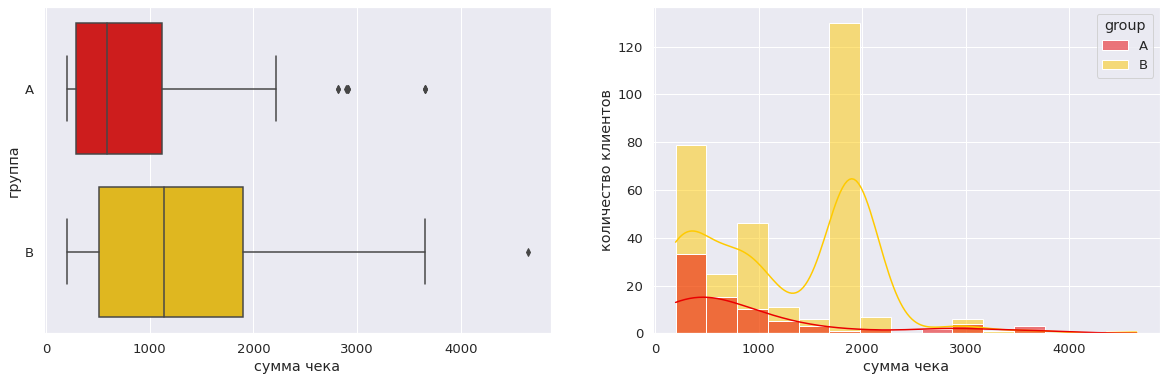

In [68]:
# визуализируем распределение оплат по группам
sns.set(font_scale=1.2, 
        rc={'figure.figsize':(20, 6)})
fig, ax = plt.subplots(1, 2)

sns.boxplot(data=customers, x='check_sum', y='group', palette='hot', ax=ax[0])
sns.histplot(data=customers, x='check_sum', hue='group', palette='hot', bins=15, kde=True, ax=ax[1])
ax[0].set(xlabel='сумма чека', ylabel='группа')
ax[1].set(xlabel='сумма чека', ylabel='количество клиентов')
plt.show()

При первоначальном анализе мы видим, что распределение в группах отклоняются от нормального, дисперсии групп равны, конверсия целевой группы уменьшилась, а ARPU и ARPPU увеличились относительно контрольной группы.

На основе А/В тестирования нам необходимо проверить, что эти значения статистически значимы и дать руководству обоснования стоит ли запускать новую механику для всех пользователей или же откатить. 

In [69]:
metrics

,group,total_sum,count_users,count_customers,CR,ARPPU,ARPU
0,A,72820.0000,1538,78,5.07,933.59,47.33
1,B,394974.0035,6803,314,4.62,1257.88,58.11


Для оценки различий между группами и проверки статистической значимости метрик `ARPU и ARPPU` воспользуемся методом `Bootstrap`. 
- Объем выборки слишком мал для применения классических статистических методов, данные не соответствуют нормальному распределению и имеют выбросы.

### ARPPU
- **H0**: ARPPU не отличаются
- **H1**: ARPPU отличаются

In [70]:
df_A_ARPPU = group_A.check_sum # значения группы_А
df_B_ARPPU = group_B.check_sum # значения группы_В

num_samples = 1000 # кол-во выборок bootstrap
bootstrap_diffs = np.zeros(num_samples) # массив, заполненный нулями
 
# Выполняем выборку
for i in range(num_samples):
    bootstrap_group1 = np.random.choice(df_A_ARPPU, size=len(df_A_ARPPU), replace=True)
    bootstrap_group2 = np.random.choice(df_B_ARPPU, size=len(df_B_ARPPU), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

# рассчитываем доверительный интервал  
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
 
print("95% Доверительный интервал ARPPU:", confidence_interval)

95% Доверительный интервал ARPPU: [-526.61711969  -96.88611985]


In [71]:
# создадим датафрейм полученных показателей для визуализации
data_ARPPU = pd.DataFrame(bootstrap_diffs, columns=['difference'])
data_ARPPU.head(2)

,difference
0,-170.001319
1,-351.227761


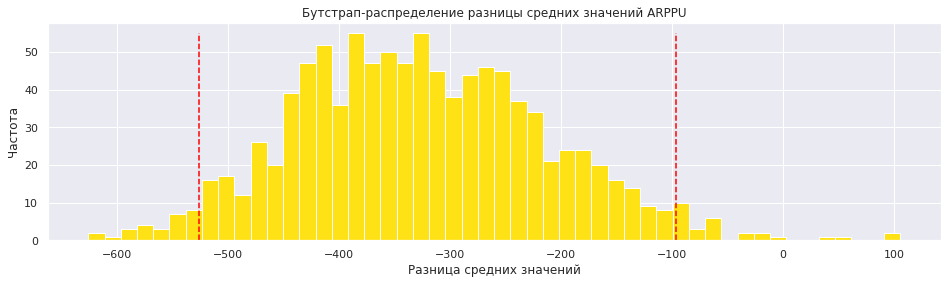

In [72]:
# визуализация Бутстрап-распределения ARPPU
sns.set(font_scale=1, 
        rc={'figure.figsize':(16, 4)}, palette='Wistia')
plt.hist(data_ARPPU['difference'], bins=50)
plt.vlines(confidence_interval, ymin=0, ymax=max(plt.hist(data_ARPPU['difference'], bins=50)[0]),
           colors='red', linestyle='--')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title("Бутстрап-распределение разницы средних значений ARPPU")
plt.show()

In [73]:
# посмотрим доверительный интервал средних для группы_А
bootstrap((df_A_ARPPU.values, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=756.475158433983, high=1171.1382685379267), standard_error=103.64821929835333)

In [74]:
# посмотрим доверительный интервал средних для группы_В
bootstrap((df_B_ARPPU.values, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1173.175618262024, high=1347.949212824476), standard_error=44.87958230431683)

С помощью метода Bootstrap мы видим, что в распределение разницы средних значений между группами **0** не попадает в 95% доверительный интервал, соответственно можем отвергнуть нулевую гипотезу и принять альтернативную: ARPPU группы_В статистически значимо отличается от ARPPU группы_А. В доверительных интервалах отдельно по каждой группе нет пересечения средних значений.

**Новая механика повлияла на увеличение среднего дохода с платящего пользователя (клиента).**

### ARPU
- **H0**: ARPU не отличаются
- **H1**: ARPU отличаются

In [75]:
df_A_ARPU = general_file_active.query('group == "A"').revenue # значения группы_А
df_B_ARPU = general_file_active.query('group == "B"').revenue # значения группы_В

num_samples = 1000 # кол-во выборок bootstrap
bootstrap_diffs_ARPU = np.zeros(num_samples)

# Выполняем выборку
for i in range(num_samples):
    bootstrap_group_A = np.random.choice(df_A_ARPU, size=len(df_A_ARPU), replace=True)
    bootstrap_group_B = np.random.choice(df_B_ARPU, size=len(df_B_ARPU), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group_A) - np.mean(bootstrap_group_B)
    bootstrap_diffs_ARPU[i] = bootstrap_diff
    
# рассчитываем доверительный интервал    
confidence_interval_ARPU = np.percentile(bootstrap_diffs_ARPU, [2.5, 97.5])
 
print("95% Доверительный интервал ARPU:", confidence_interval_ARPU)

95% Доверительный интервал ARPU: [-25.69375409   7.16240536]


In [76]:
# создадим датафрейм полученных показателей для визуализации
data_ARPU = pd.DataFrame(bootstrap_diffs_ARPU, columns={'difference_ARPU'})
data_ARPU.head(2)

,difference_ARPU
0,-9.710155
1,-1.071349


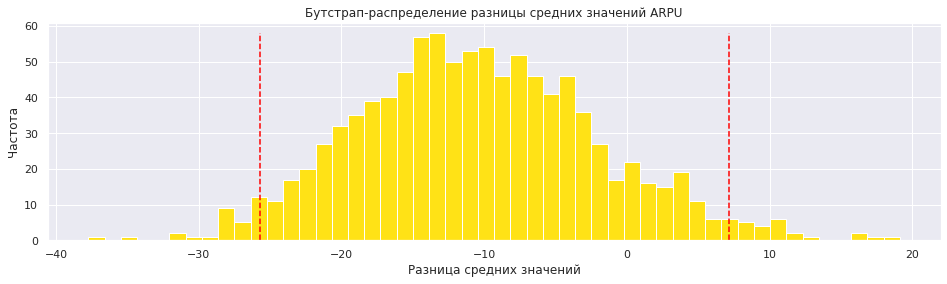

In [77]:
# визуализация Бутстрап-распределения ARPU
sns.set(font_scale=1, 
        rc={'figure.figsize':(16, 4)}, palette='Wistia')
plt.hist(data_ARPU['difference_ARPU'], bins=50)
plt.vlines(confidence_interval_ARPU, ymin=0, ymax=max(plt.hist(data_ARPU['difference_ARPU'], bins=50)[0]),
           colors='red', linestyle='--')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title("Бутстрап-распределение разницы средних значений ARPU")
plt.show()

In [78]:
# посмотрим доверительный интервал средних для группы_А
bootstrap((df_A_ARPU.values, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=34.5260078023407, high=64.68232332409877), standard_error=7.520934915348638)

In [79]:
# посмотрим доверительный интервал средних для группы_В
bootstrap((df_B_ARPU.values, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=51.02354354530693, high=66.10987213610821), standard_error=3.8150044316824157)

С помощью метода Bootstrap мы видим, что в распределение разницы средних значений между группами **0** попадает в 95% доверительный интервал, соответственно принимаем нулевую гипотезу: ARPU группы_В статистически значимо не отличается от ARPU группы_А. В доверительных интервалах отдельно по каждой группе наблюдаем пересечение средних значений.

**Новая механика не повлияла на увеличение среднего дохода от одного пользователя.**

In [80]:
metrics

,group,total_sum,count_users,count_customers,CR,ARPPU,ARPU
0,A,72820.0000,1538,78,5.07,933.59,47.33
1,B,394974.0035,6803,314,4.62,1257.88,58.11


In [81]:
 general_file_active.head(2)

,id,group,active,revenue,paid
1,1627,A,1.0,990.0,1.0
10,2085,B,1.0,0.0,0.0


`Метод Хи-квадрат Пирсона` - статистический тест, применяемый к наборам категориальных данных для оценки вероятности того, что какая-либо наблюдаемая разница между наборами возникла случайно.
С помощью этого метода проверим нулевую гипотезу, что конверсия в группах не имеет различий. Для этого мы создадим таблицу сопряженности и в нашем случае категориальными данными будут `"active"` - пользователи, которые участвовали в дни эксперимента, и `"paid"` - пользователи, которые произвели покупку в дни эксперимента.

### CR
- **H0:** CR не отличаются
- **H1:** CR отличаются
- уровень значимости 0.05

In [82]:
table = pd.crosstab(general_file_active['group'], general_file_active['paid'])
table

paid,0.0,1.0
group,,
A,1460,78
B,6489,314


In [83]:
chi2, p_value, dof, expected = chi2_contingency(table)
print(f"χ²: {chi2}, p-значение: {p_value}")

χ²: 0.48480826522557896, p-значение: 0.48625240457231045


С помощью метода Хи-квадрат Пирсона мы видим, что р-значение > 0.05, соответственно принимаем нулевую гипотезу: CR группы_В статистически значимо не отличается от CR группы_А. 

**Новая механика не повлияла на конверсию.**

In [84]:
metrics

,group,total_sum,count_users,count_customers,CR,ARPPU,ARPU
0,A,72820.0000,1538,78,5.07,933.59,47.33
1,B,394974.0035,6803,314,4.62,1257.88,58.11


### Вывод о проведении эксперимента 

Целевой группе_В была предложена новая механика оплаты услуг на сайте, у контрольной группы_А оставалась базовая механика. 

В ходе анализа данных и расчета основных метрик видим:
- контрольная группа_А в 4-5 раз меньше по количеству пользователей целевой группы_В
- значительное увеличение метрики ARPPU целевой группы_В на 34.7% (в нашем случае это средний чек, т.к все id в файле active_studs.csv уникальны и произвели покупку 1 раз) относительно контрольной группы_А
- снижение конверсии на 8.9% у целевой группы_В
- увеличение метрики ARPU целевой группы_В на 22.6%

Мы применили методы A/B–тестирования, чтобы понять как разница количества пользователей в группах влияет на метрики и подтверждает наши расчеты. 

По итогам тестирования у нас подтвердилось:
- ARPPU целевой группы_В имеют отличия от ARPPU контрольной группы_А
- ARPU целевой группы_В не имеют отличия от ARPU контрольной группы_А
- CR целевой группы_В не имеют отличия от CR контрольной группы_А

Новую механику оплаты услуг на сайте нужно запускать, она влияет на рост среднего чека и не изменяет конверсию, т.е принесет бизнесу деньги, а клиентам - комфортабельные условия взаимодействия с платформой. 

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

- таблица default.peas:

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! 
Под **усердным студентом** мы понимаем студента, который правильно **решил 20 задач за текущий месяц.**

In [88]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [89]:
# посмотрим на данные default.peas
query = """
    SELECT
        st_id,
        toDateTime(timest) as timest,
        correct,
        subject
    FROM peas 
"""
peas = ph.read_clickhouse(query, connection=connection)
peas.head(3)

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability


In [90]:
print(f'Кол-во уникальных студентов - {peas.st_id.nunique()}')
print(f'Виды дисциплин - {peas.subject.unique()}')
print(f'Минимальная дата решения  - {peas.timest.min()}')
print(f'Максимальная дата решения  - {peas.timest.max()}')
print(f'Период решения - {peas.timest.max()-peas.timest.min()}')
print(f'Кол-во решений - {peas.correct.sum()}')

Кол-во уникальных студентов - 308
Виды дисциплин - ['Theory of probability' 'Vizualization' 'Python' 'Statistics' 'Math']
Минимальная дата решения  - 2021-10-30 13:00:00
Максимальная дата решения  - 2021-10-31 17:29:52
Период решения - 1 days 04:29:52
Кол-во решений - 6764


In [93]:
query = """
    SELECT 
        COUNT(DISTINCT st_id) as count_student
    FROM
        (
        SELECT  
            st_id,
            count(correct) as count_correct
        FROM peas
        WHERE correct = 1  
        GROUP BY st_id 
        HAVING count_correct >=20
        )
"""
count_student = ph.read_clickhouse(query, connection=connection)
print(f'Кол-во усердных студентов, которые правильно решили 20 задач за текущий месяц, {count_student.count_student[0]} человек.')

Кол-во усердных студентов, которые правильно решили 20 задач за текущий месяц, 136 человек.


## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

- таблицы: default.peas, default.studs и default.final_project_check
	
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

- **Активным** считается пользователь, за все время решивший **больше 10 задач** правильно в любых дисциплинах.

- **Активным по математике** считается пользователь, за все время решивший **2 или больше задач** правильно по математике.

### Метрики 

**ARPU (Average Revenue Per User)** - средний платеж на всех зарегистрированных игроков.
- `ARPU = доход / кол-во зарегистрированных (уникальных) пользователей`

**ARPAU (Average Revenue Per Active User)** - средний платеж на всех активных пользователей. 
- `ARPAU = доход активных клиентов (больше 10 задач) / количество активных пользователей (больше 10 задач)`

**CR (Convertion rate)** - процент пользователей, которые совершили целевое действие/покупку
- `CR = количество пользователей, совершивших покупку / количество пользователей * 100`

**СR_active** - процент активного пользователя в покупку
- `CR_active = количество пользователей, совершивших покупку / количество активных пользователей (больше 10 задач) * 100`

**CR_math** - процент активного пользователя по математике (subject = ’math’) в покупку курса по математике
- `CR_math = количество пользователей, совершивших покупку по математике (больше 2-х задач) / количество активных пользователей по матеиматике (больше 2-х задач) * 100`

In [94]:
# посмотрим на данные default.final_project_check
query = """
    SELECT 
        st_id,
        toDateTime(sale_time) as sale_time,
        money,
        subject
    FROM default.final_project_check 
"""
check = ph.read_clickhouse(query, connection=connection)
print(check.shape[0])
check.head(2)

61


,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization


In [95]:
# посмотрим на данные default.studs
query = """
SELECT *
FROM default.studs
"""
studs = ph.read_clickhouse(query, connection=connection)
print(studs.shape[0])
studs.head(2)

600


,st_id,test_grp
0,100379,pilot
1,101432,control


In [96]:
print(peas.shape[0])
peas.head(2)

13245


,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization


In [97]:
query = """
SELECT 
    test_grp,
    sum(money) AS revenue,
    uniqExact(st_id) AS count_users,
    countIf(DISTINCT st_id, money > 0) AS count_customers,
    countIf(DISTINCT st_id, active_stud > 10 and money > 0) AS count_active_customers,
    countIf(DISTINCT st_id, math_active_stud >= 2 and money > 0 and subject = 'Math') AS count_math_customers,
    round(revenue / count_users, 2) AS ARPU,
    round(sumIf(money, active_stud > 10) / countIf(DISTINCT st_id, active_stud > 10), 2) AS ARPAU,
    round(count_customers / count_users * 100,2) AS CR, 
    round(count_active_customers / countIf(DISTINCT st_id, active_stud >10) * 100, 2) AS CR_active,
    round(count_math_customers / countIf(DISTINCT st_id, math_active_stud >= 2)*100, 2) AS CR_math
FROM
    (
        SELECT 
            l.test_grp AS test_grp,
            l.st_id AS st_id,
            r.sale_time AS sale_time,
            r.money AS money,
            r.subject AS subject,
            s.active_stud AS active_stud,
            s.math_active_stud AS math_active_stud
        FROM studs AS l
        LEFT JOIN final_project_check AS r    
        ON l.st_id = r.st_id  
        LEFT JOIN 
            (SELECT 
                st_id,
                SUM(correct) AS active_stud,
                SUM(CASE WHEN subject = 'Math' THEN correct ELSE 0 END) AS math_active_stud
            FROM peas  
            GROUP BY st_id
            ) AS s
        ON l.st_id = s.st_id 
    )
GROUP BY test_grp
"""
metrics_SQL = ph.read_clickhouse(query, connection=connection)
metrics_SQL

,test_grp,revenue,count_users,count_customers,count_active_customers,count_math_customers,ARPU,ARPAU,CR,CR_active,CR_math
0,control,1385000,305,15,14,3,4540.98,10393.70,4.92,11.02,6.12
1,pilot,3395000,295,32,25,4,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python
### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [98]:
def function_to_add_groups(groups, groups_add, active_studs, checks):
    ''' Функция для автоматической загрузки данных из дополнительного файла groups_add.csv,
    которая получает данные через API, переименовывает заголовки, склеивает таблицы, рассчитывает 
    основные метрики для каждой группы и собирает их в общую таблицу для анализа эксперимента
    '''
    import pandas as pd
    from urllib.parse import urlencode
    import requests
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    groups_add = pd.read_csv(download_url)
    
    active_studs['active'] = 1
    checks['paid'] = 1
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    
    shared_group = pd.concat([groups, groups_add]).rename(columns={'grp': 'group'})
    active_checks = active_studs.merge(checks, on='id', how = 'left').rename(columns={'rev': 'revenue'})
    general_file = shared_group.merge(active_checks, on='id', how= 'left').fillna(0)
    
    general_file_active = general_file.query('active == 1')
    group_A = general_file_active.query('group == "A" and paid == 1')
    group_B = general_file_active.query('group == "B" and paid == 1')
    
    CR_A = round(group_A.id.count() / general_file_active.query('group == "A"').id.count() * 100, 2)
    CR_B = round(group_B.id.count() / general_file_active.query('group == "B"').id.count() * 100, 2)
    ARPPU_A = round(group_A.revenue.sum() / group_A.id.count(), 2)
    ARPPU_B = round(group_B.revenue.sum() / group_B.id.count(), 2)
    ARPU_A = round(CR_A * ARPPU_A /100, 2)
    ARPU_B = round(CR_B * ARPPU_B/100, 2)
    
    metrics = pd.DataFrame({
             'group': ['A', 'B'], 
             'total_sum': [group_A.revenue.sum(), group_B.revenue.sum()],
             'count_users': [general_file_active.query('group=="A"').id.count(),
                            general_file_active.query('group=="B"').id.count()],
             'count_customers': [group_A.id.count(), group_B.id.count()],
             'CR': [CR_A, CR_B],
             'ARPPU': [ARPPU_A, ARPPU_B],
             'ARPU': [ARPU_A, ARPU_B]
             })
    return metrics

In [99]:
metrics_function = function_to_add_groups(groups, groups_add, active_studs, checks)
metrics_function

,group,total_sum,count_users,count_customers,CR,ARPPU,ARPU
0,A,72820.0000,1538,78,5.07,933.59,47.33
1,B,394974.0035,6803,314,4.62,1257.88,58.11


In [100]:
def vizual_metrics(metrics_function):
    ''' Функция для визуализации графиков по полученным метрикам
    '''
    sns.set(font_scale=1.3, 
            rc={'figure.figsize':(24, 5)})
    f, (ax_1, ax_2, ax_3, ax_4, ax_5, ax_6) = plt.subplots(1, 6)
    
    sns.barplot(data=metrics_function, x= 'group', y = 'total_sum', palette= 'hot', ax=ax_1)
    ax_1.set(xlabel = '', ylabel = '', title ='Total sum')
    
    sns.barplot(data=metrics_function, x= 'group', y = 'count_users', palette= 'hot', ax=ax_2)
    ax_2.set(xlabel = '', ylabel = '', title = 'Count users')
    
    sns.barplot(data=metrics_function, x= 'group', y = 'count_customers', palette= 'hot', ax=ax_3)
    ax_3.set(xlabel = '', ylabel = '', title = 'Count customers')
    
    sns.barplot(data=metrics_function, x= 'group', y = 'CR', palette= 'hot', ax=ax_4)
    ax_4.set(xlabel = '', ylabel = '', title ='CR')
    
    sns.barplot(data=metrics_function, x= 'group', y = 'ARPPU', palette= 'hot', ax=ax_5)
    ax_5.set(xlabel = '', ylabel = '', title ='ARPPU')
    
    sns.barplot(data=metrics_function, x= 'group', y = 'ARPU', palette= 'hot', ax=ax_6)
    ax_6.set(xlabel = '', ylabel = '', title ='ARPU')
    
    plt.show() 

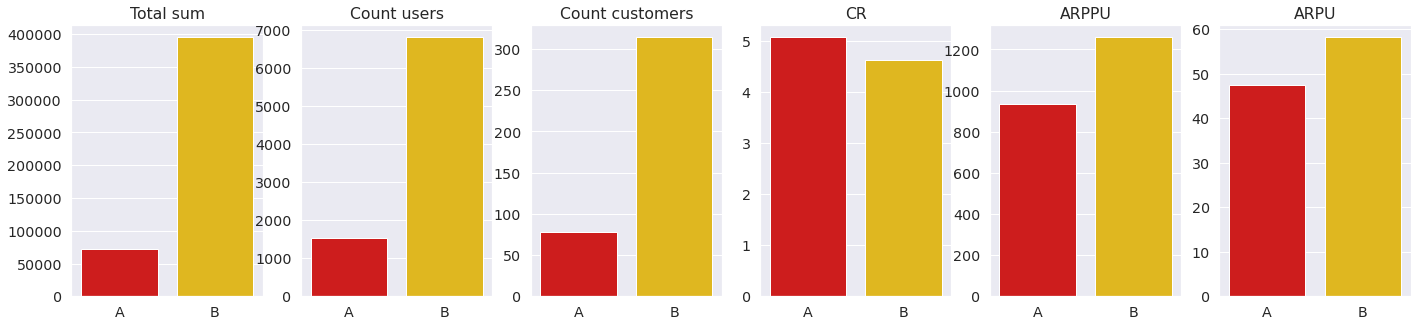

In [101]:
vizual_metrics(metrics_function)